# Validação do treinamento


Baixando dataset de treinamento e de validação

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Rede

In [14]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropOut = nn.Dropout(0.2)
        
    def forward(self, x):
        # garante um vetor de uma dimensão
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropOut(x)
        x = F.relu(self.fc2(x))
        x = self.dropOut(x)
        x = F.relu(self.fc3(x))
        x = self.dropOut(x)
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

### Acuracia sem treinamento

In [15]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


- ***ps.topk***

Retorna os k maiores valores.

Para retornar apenas a classe mais semelhante usamos *ps.topk(1)*. 

Retorna uma tupla de top-valores e top-indices

In [16]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])


In [17]:
equals = top_class == labels.view(*top_class.shape)
equals[:10]

tensor([[False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [18]:
accuracy = torch.mean(equals)
print(f'Accuracy: {accuracy.item()*100}%')

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Bool

In [19]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


## Treinamento com validação

In [20]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [21]:
epochs = 25
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            test_correct = 0
            
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)                
                test_loss += loss.item()
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                # soma de respostas corretas em todos os batchs
                test_correct += equals.sum().item()
            
        train_loss = running_loss / len(trainloader.dataset)
        test_loss = test_loss / len(testloader.dataset)
        
        # fim da epoca
        train_losses.append(train_loss)
        test_losses.append(test_loss)


        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))
        

Epoch: 1/25..  Training Loss: 0.010..  Test Loss: 0.008..  Test Accuracy: 0.824
Epoch: 2/25..  Training Loss: 0.008..  Test Loss: 0.007..  Test Accuracy: 0.838
Epoch: 3/25..  Training Loss: 0.007..  Test Loss: 0.006..  Test Accuracy: 0.847
Epoch: 4/25..  Training Loss: 0.007..  Test Loss: 0.006..  Test Accuracy: 0.853
Epoch: 5/25..  Training Loss: 0.007..  Test Loss: 0.006..  Test Accuracy: 0.852
Epoch: 6/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.859
Epoch: 7/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.855
Epoch: 8/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.859
Epoch: 9/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.862
Epoch: 10/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.863
Epoch: 11/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.866
Epoch: 12/25..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.863
Epoch: 13/25..  Training Loss: 0.006.

- **Plotar resultado**

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

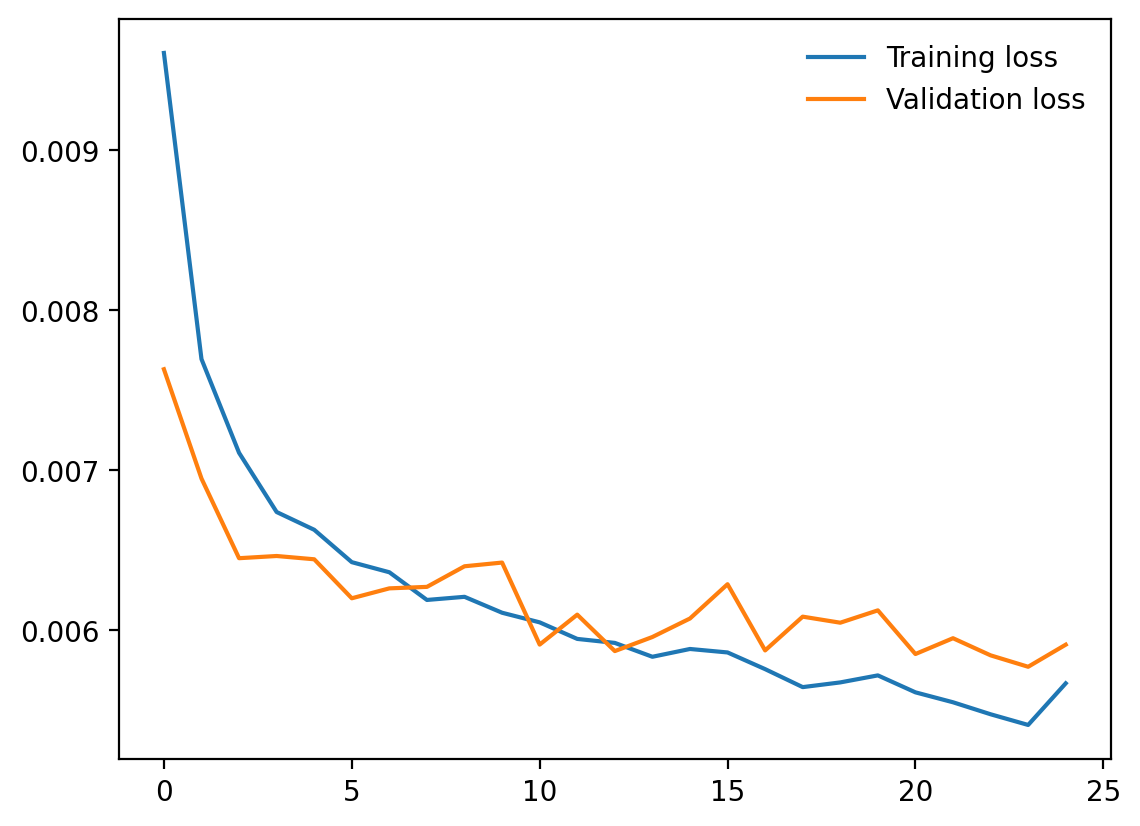

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## salvar e carregar os modelos

São salvos os parametros aprendidos (pesos e bias). Dessa maneira, a arquitetrura da rede deve ser definida hardcoded.
O Tensoflow salva também as informações da rede, para fazer isso com o **Pytorch** deve-se salvar como **onnx**

In [24]:
torch.save(model.state_dict(), 'checkpoint.pth')

- Carregando

O modelo deve ser criado e depois recebe os parametros carregados